In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
%matplotlib inline

In [2]:
ruta = "chicago_taxi_trips_2016_01.csv"
df = pd.read_csv(ruta)
df.head()

,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,fare,tips,tolls,extras,trip_total,payment_type,company,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
0,85.0,2016-1-13 06:15:00,2016-1-13 06:15:00,180.0,0.40,NaN,NaN,24.0,24.0,4.50,0.00,0.0,0.0,4.50,Cash,107.0,199.0,510.0,199.0,510.0
1,2776.0,2016-1-22 09:30:00,2016-1-22 09:45:00,240.0,0.70,NaN,NaN,NaN,NaN,4.45,4.45,0.0,0.0,8.90,Credit Card,NaN,NaN,NaN,NaN,NaN
2,3168.0,2016-1-31 21:30:00,2016-1-31 21:30:00,0.0,0.00,NaN,NaN,NaN,NaN,42.75,5.00,0.0,0.0,47.75,Credit Card,119.0,NaN,NaN,NaN,NaN
3,4237.0,2016-1-23 17:30:00,2016-1-23 17:30:00,480.0,1.10,NaN,NaN,6.0,6.0,7.00,0.00,0.0,0.0,7.00,Cash,NaN,686.0,500.0,686.0,500.0
4,5710.0,2016-1-14 05:45:00,2016-1-14 06:00:00,480.0,2.71,NaN,NaN,32.0,NaN,10.25,0.00,0.0,0.0,10.25,Cash,NaN,385.0,478.0,NaN,NaN


In [3]:
df.columns

Index(['taxi_id', 'trip_start_timestamp', 'trip_end_timestamp', 'trip_seconds',
       'trip_miles', 'pickup_census_tract', 'dropoff_census_tract',
       'pickup_community_area', 'dropoff_community_area', 'fare', 'tips',
       'tolls', 'extras', 'trip_total', 'payment_type', 'company',
       'pickup_latitude', 'pickup_longitude', 'dropoff_latitude',
       'dropoff_longitude'],
      dtype='object')

In [4]:
var = ['taxi_id','trip_seconds','trip_miles',
       'fare', 'tips','tolls', 'extras', 'trip_total', 'company',
       'pickup_latitude', 'pickup_longitude']

In [5]:
aux = df[var]

In [6]:
aux.dropna(inplace = True)
aux.reset_index(drop=True,inplace=True)

/home/diegoias/Documents/CieciaDatos/cdd/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


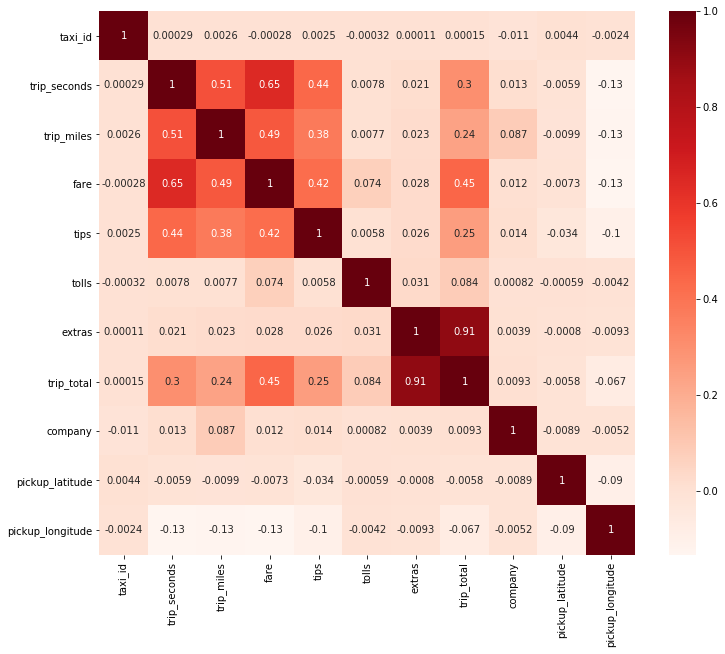

In [7]:
plt.figure(figsize=(12,10))
cor = aux.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [8]:
cor_target = abs(cor["trip_seconds"])
revelant_features = cor_target[cor_target>0.5]
revelant_features

trip_seconds    1.000000
trip_miles      0.510945
fare            0.647906
Name: trip_seconds, dtype: float64

In [9]:
var = list(aux.columns)
var =  [x for x in var if x != 'trip_seconds']

### Wrapper Method 

Backward Elimination

In [10]:
X = aux[var]
y = aux['trip_seconds']

In [11]:
cols = list(X.columns)
pmax = 1

while (len(cols)>0):
    p = []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax > 0.05):
        cols.remove(feature_with_p_max)
    else:
        break
        
selected_features_BE = cols
print(selected_features_BE)

/home/diegoias/Documents/CieciaDatos/cdd/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


['trip_miles', 'fare', 'tolls', 'extras', 'trip_total', 'company', 'pickup_latitude', 'pickup_longitude']


Recursive Feature Elimination (RFE)

In [12]:

#Número de características
nof_list = np.arange(1,10)            
high_score = 0

#Proceso para almacenar las características óptimas
nof = 0           
score_list = []

for n in range(len(nof_list)):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 0)
    model = LinearRegression()
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
        
print("Número óptimo de características: %d" %nof)
print("Desempeño con %d características: %f" % (nof, high_score))

Número óptimo de características: 3
Desempeño con 3 características: 0.192136


In [13]:
cols = list(X.columns)
model = LinearRegression()
#Initializing RFE model
rfe = RFE(model, 3)             
#Transforming data using RFE
X_rfe = rfe.fit_transform(X,y)  
#Fitting the data to model
model.fit(X_rfe,y)              
temp = pd.Series(rfe.support_,index=cols)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

Index(['tolls', 'extras', 'trip_total'], dtype='object')


Embedded Method

In [14]:
reg = LassoCV()
reg.fit(X, y)
coef = pd.Series(reg.coef_, index = X.columns)
print("Número óptimo de características:" + str(sum(coef != 0)))
print("Desempeño mediante la regularización Lasso: %f" %reg.score(X,y))

/home/diegoias/Documents/CieciaDatos/cdd/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Número óptimo de características:3
Desempeño mediante la regularización Lasso: 0.347557
